# **2. Mohammad & Turney (2013) - NRC Word-Emotion Association Lexicon**

In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import files
import io
import warnings
from itertools import combinations

warnings.filterwarnings('ignore')

# Uploading Files
print("Please upload the 10 NRC emotion text files ")
uploaded = files.upload()

Please upload the 10 NRC emotion text files 


Saving anger-NRC-Emotion-Lexicon.txt to anger-NRC-Emotion-Lexicon.txt
Saving anticipation-NRC-Emotion-Lexicon.txt to anticipation-NRC-Emotion-Lexicon.txt
Saving disgust-NRC-Emotion-Lexicon.txt to disgust-NRC-Emotion-Lexicon.txt
Saving fear-NRC-Emotion-Lexicon.txt to fear-NRC-Emotion-Lexicon.txt
Saving joy-NRC-Emotion-Lexicon.txt to joy-NRC-Emotion-Lexicon.txt
Saving negative-NRC-Emotion-Lexicon.txt to negative-NRC-Emotion-Lexicon.txt
Saving positive-NRC-Emotion-Lexicon.txt to positive-NRC-Emotion-Lexicon.txt
Saving sadness-NRC-Emotion-Lexicon.txt to sadness-NRC-Emotion-Lexicon.txt
Saving surprise-NRC-Emotion-Lexicon.txt to surprise-NRC-Emotion-Lexicon.txt
Saving trust-NRC-Emotion-Lexicon.txt to trust-NRC-Emotion-Lexicon.txt


In [4]:
# Auto-detection emotion files from uploaded names
dfs = []
for filename in uploaded.keys():
    for emotion in ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                    'negative', 'positive', 'sadness', 'surprise', 'trust']:
        if emotion in filename.lower():

            lines = io.BytesIO(uploaded[filename]).read().decode('utf-8').splitlines()
            # Split by tab and keep only words with association == 1
            words = [line.split('\t')[0] for line in lines if len(line.split('\t')) == 2 and line.split('\t')[1]=='1']
            temp = pd.DataFrame(words, columns=['word'])
            temp['emotion'] = emotion
            dfs.append(temp)
            print(f" Loaded {filename} as {emotion} ({len(words)} words)")
            break

# Combining all into DataFrame
df = pd.concat(dfs, ignore_index=True)
df['word'] = df['word'].astype(str).str.strip()  # clean words
df.drop_duplicates(inplace=True)            # remove duplicates
print(f"\n Loaded {df.shape[0]} total words from {len(dfs)} emotion files.\n")
df.head()

# Computing polarity & subjectivity immediately after cleaning
df['polarity'] = df['word'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['subjectivity'] = df['word'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

 Loaded anger-NRC-Emotion-Lexicon.txt as anger (1245 words)
 Loaded anticipation-NRC-Emotion-Lexicon.txt as anticipation (837 words)
 Loaded disgust-NRC-Emotion-Lexicon.txt as disgust (1056 words)
 Loaded fear-NRC-Emotion-Lexicon.txt as fear (1474 words)
 Loaded joy-NRC-Emotion-Lexicon.txt as joy (687 words)
 Loaded negative-NRC-Emotion-Lexicon.txt as negative (3316 words)
 Loaded positive-NRC-Emotion-Lexicon.txt as positive (2308 words)
 Loaded sadness-NRC-Emotion-Lexicon.txt as sadness (1187 words)
 Loaded surprise-NRC-Emotion-Lexicon.txt as surprise (532 words)
 Loaded trust-NRC-Emotion-Lexicon.txt as trust (1230 words)

 Loaded 13872 total words from 10 emotion files.



In [5]:
# Cleaning
df['word'] = df['word'].str.strip().str.lower()
df.drop_duplicates(inplace=True)
print("After cleaning:")
print(df.isnull().sum())
print(f"Unique words: {df['word'].nunique()}")

After cleaning:
word            0
emotion         0
polarity        0
subjectivity    0
dtype: int64
Unique words: 6453


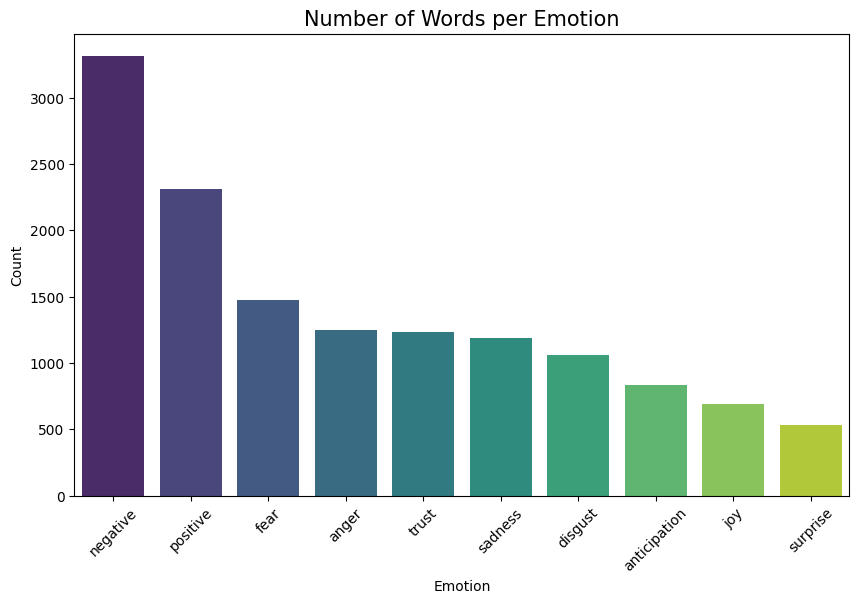

In [6]:
# Word Count by Emotion:
plt.figure(figsize=(10,6))
sns.countplot(x='emotion', data=df, palette='viridis', order=df['emotion'].value_counts().index)
plt.title('Number of Words per Emotion', size=15)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

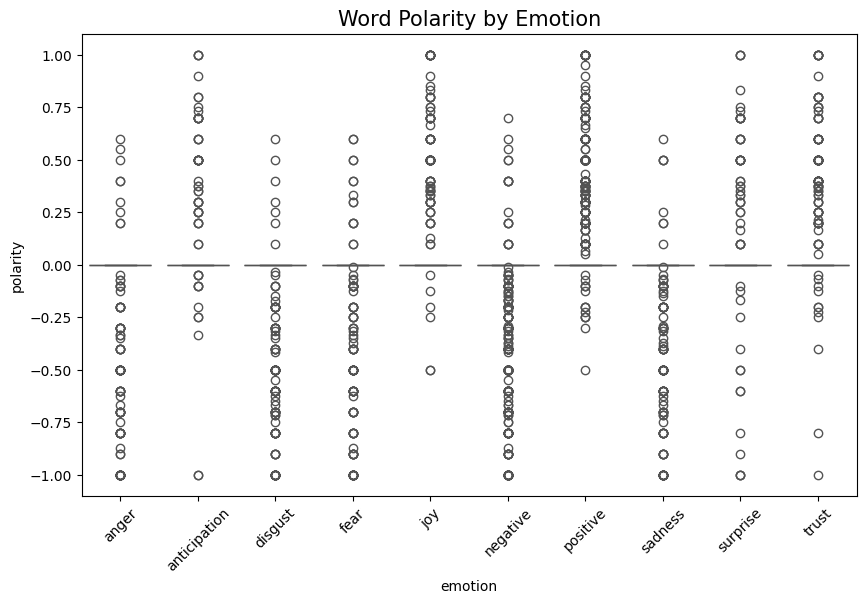

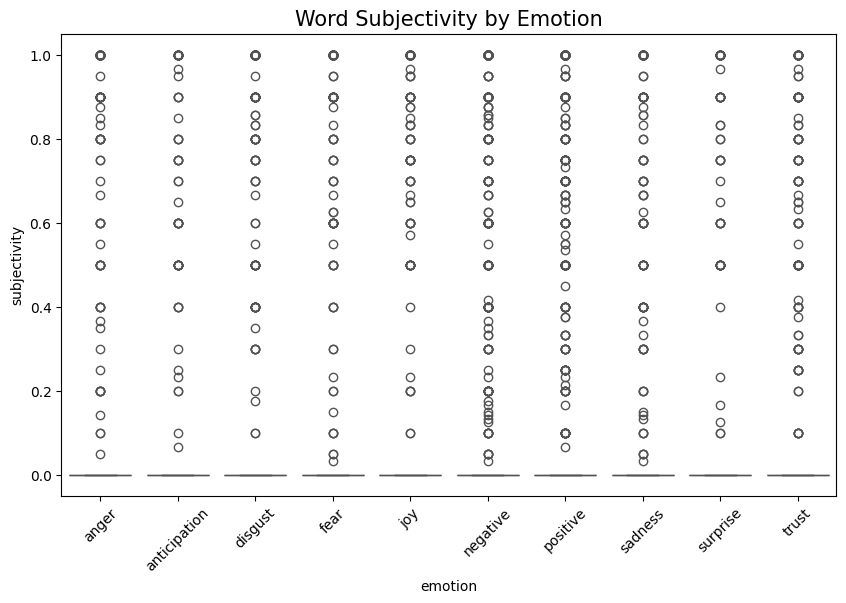

In [7]:
# Polarity & Subjectivity
df['polarity'] = df['word'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['word'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

plt.figure(figsize=(10,6))
sns.boxplot(x='emotion', y='polarity', data=df, palette='coolwarm')
plt.title('Word Polarity by Emotion', size=15)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='emotion', y='subjectivity', data=df, palette='coolwarm')
plt.title('Word Subjectivity by Emotion', size=15)
plt.xticks(rotation=45)
plt.show()

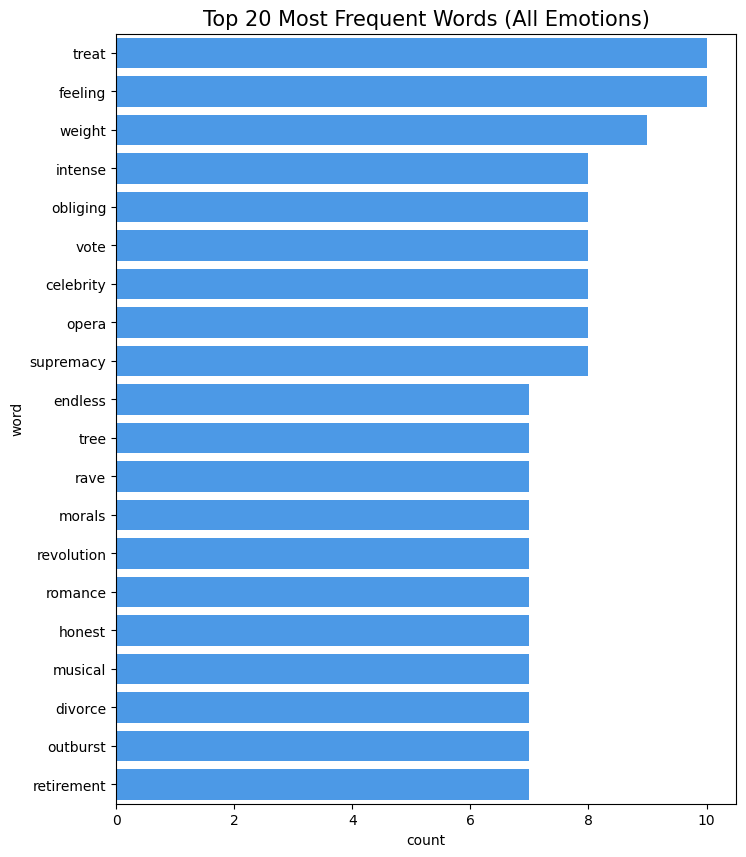

In [8]:
# Top 20 Frequent Words
top_words = df['word'].value_counts().reset_index()
top_words.columns = ['word', 'count']
top_words = top_words.head(20)

plt.figure(figsize=(8,10))
sns.barplot(y='word', x='count', color='#3399ff', data=top_words)
plt.title('Top 20 Most Frequent Words (All Emotions)', size=15)
plt.show()

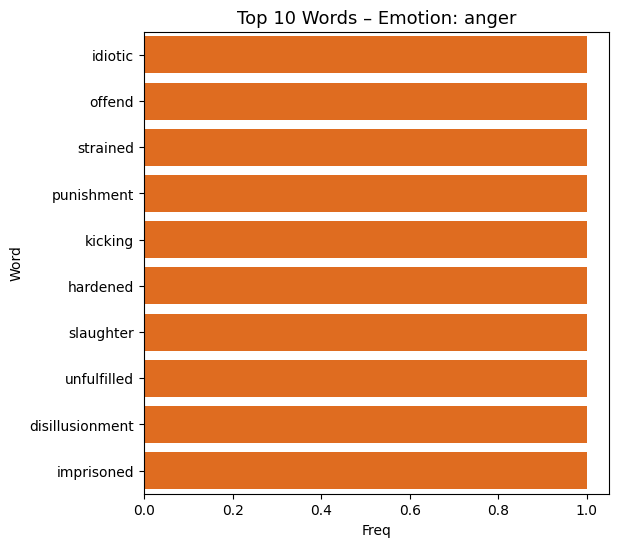

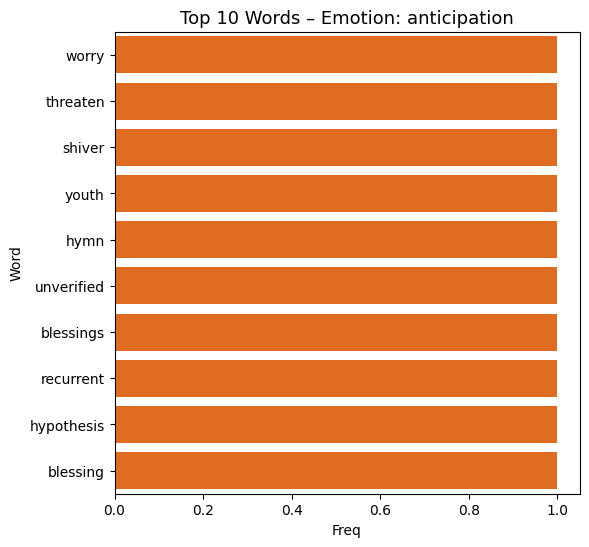

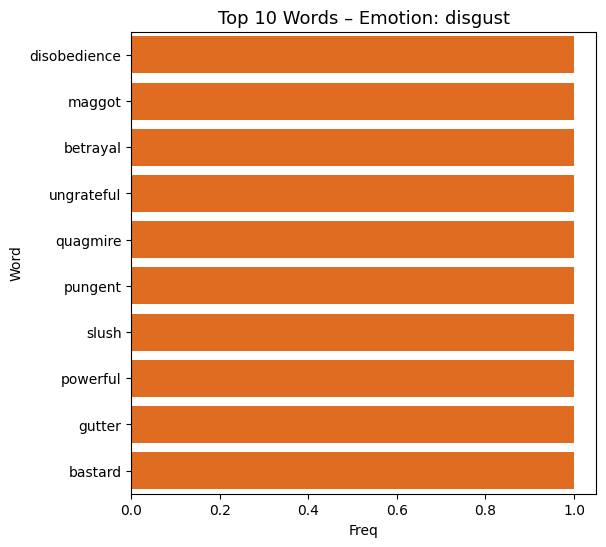

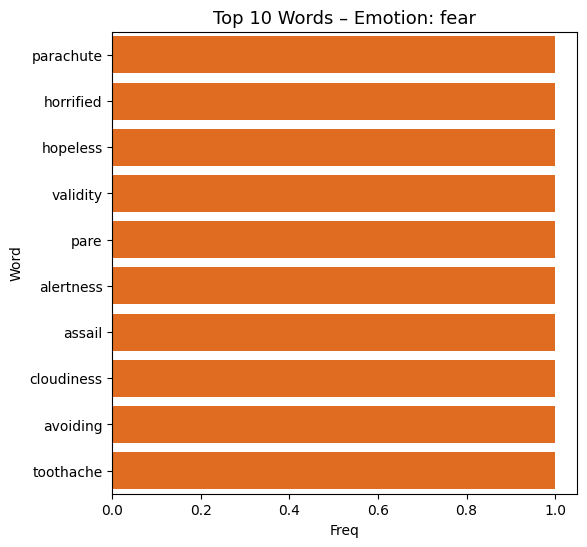

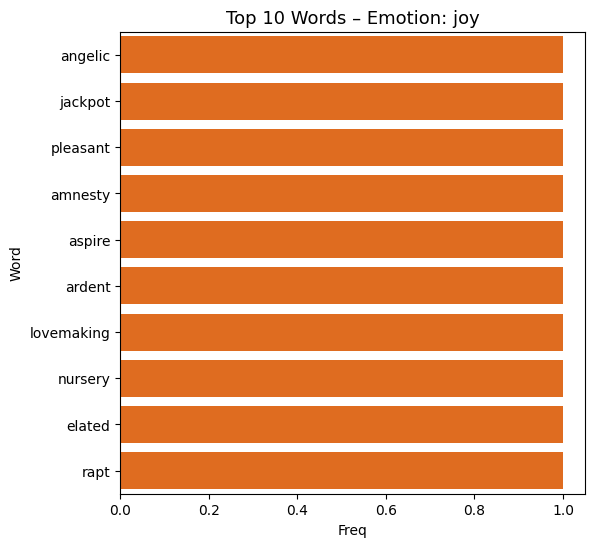

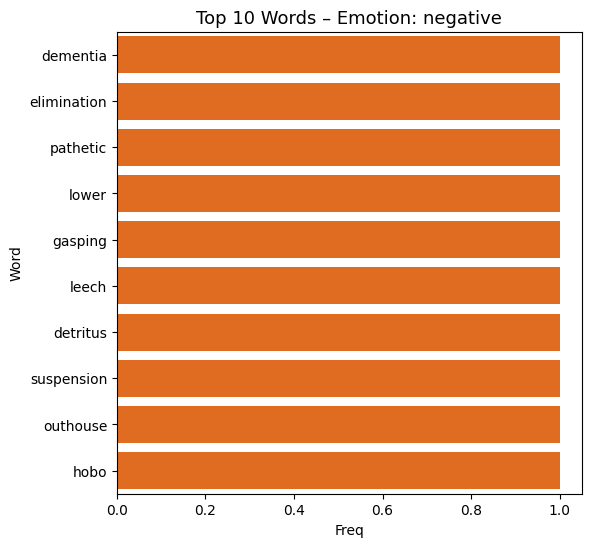

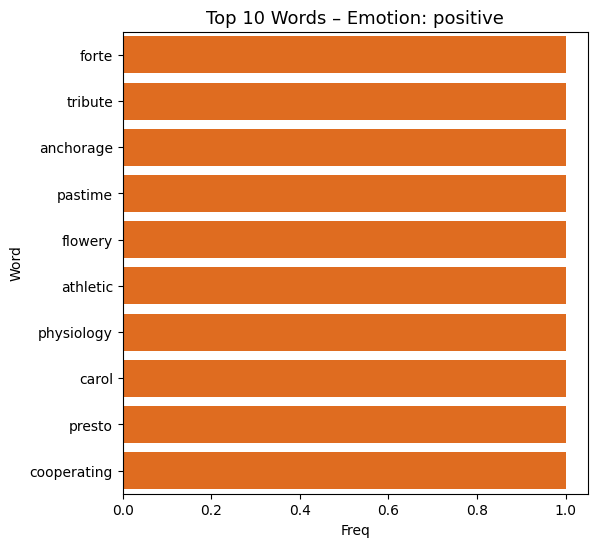

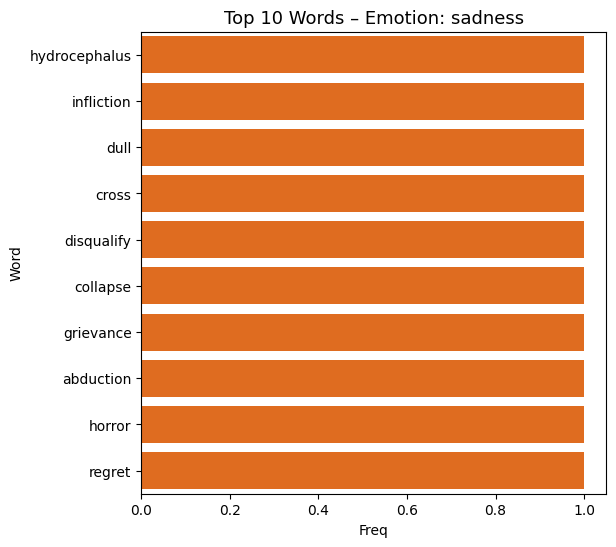

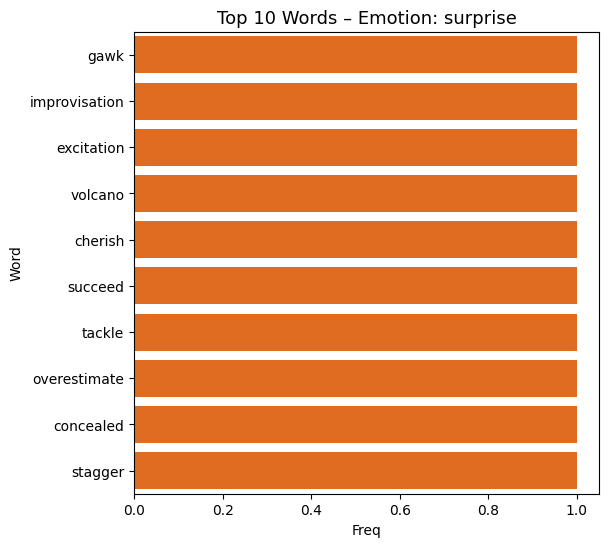

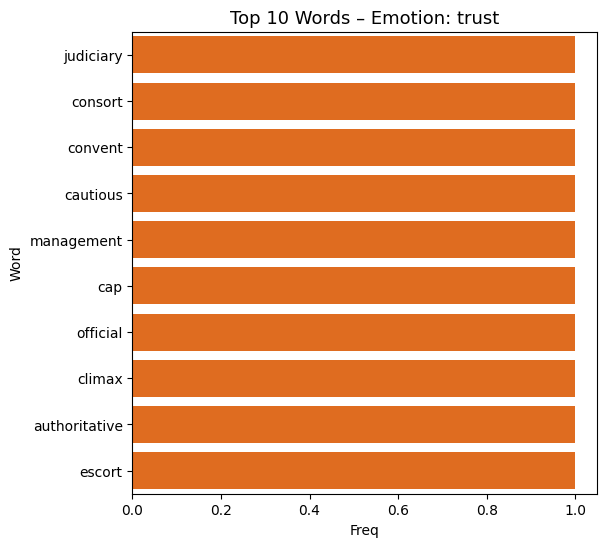

In [9]:
# N-Gram Analysis
def get_top_ngrams(corpus, ngram_range, stop_words=None, n=20):
    vec = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:n], columns=['Word', 'Freq'])

for emotion in df['emotion'].unique():
    corpus = df.loc[df['emotion'] == emotion, 'word']
    unigrams = get_top_ngrams(corpus, (1,1), n=10)
    plt.figure(figsize=(6,6))
    sns.barplot(y='Word', x='Freq', color='#ff6600', data=unigrams)
    plt.title(f'Top 10 Words – Emotion: {emotion}', size=13)
    plt.show()

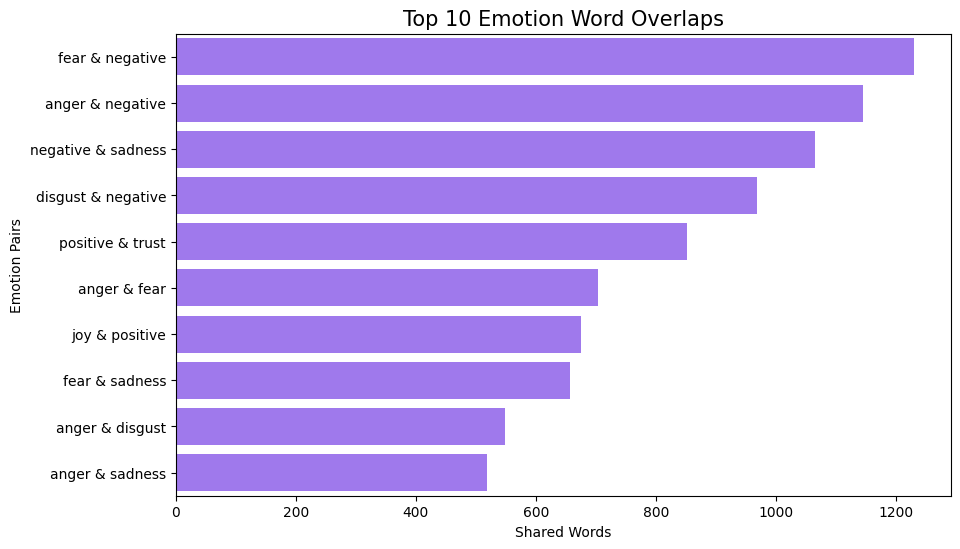

In [10]:
# Emotion Overlap
overlap = []
emotions = df['emotion'].unique()

for e1, e2 in combinations(emotions, 2):
    overlap_count = len(set(df[df.emotion==e1].word) & set(df[df.emotion==e2].word))
    overlap.append((e1, e2, overlap_count))

overlap_df = pd.DataFrame(overlap, columns=['emotion_1', 'emotion_2', 'overlap'])
top_overlap = overlap_df.sort_values('overlap', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    x='overlap',
    y=top_overlap.apply(lambda x: f"{x['emotion_1']} & {x['emotion_2']}", axis=1),
    color='#9966ff',
    data=top_overlap
)
plt.title('Top 10 Emotion Word Overlaps', size=15)
plt.xlabel('Shared Words')
plt.ylabel('Emotion Pairs')
plt.show()

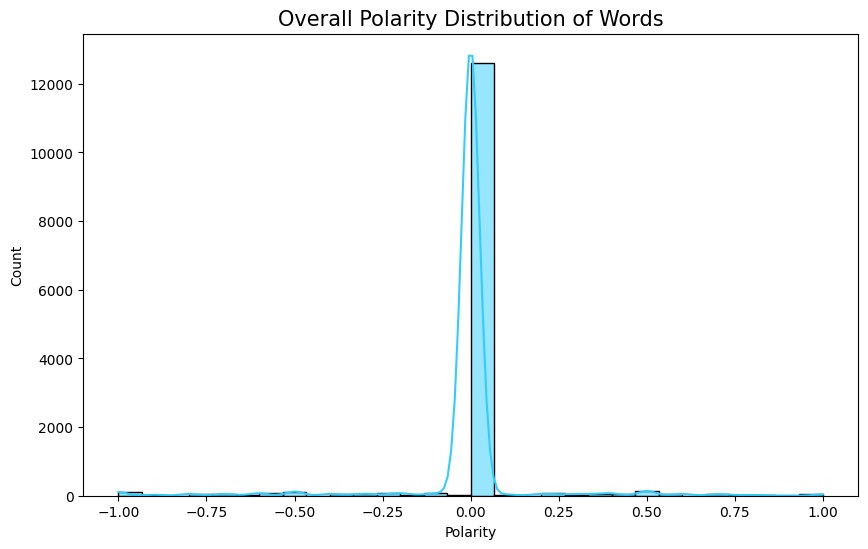

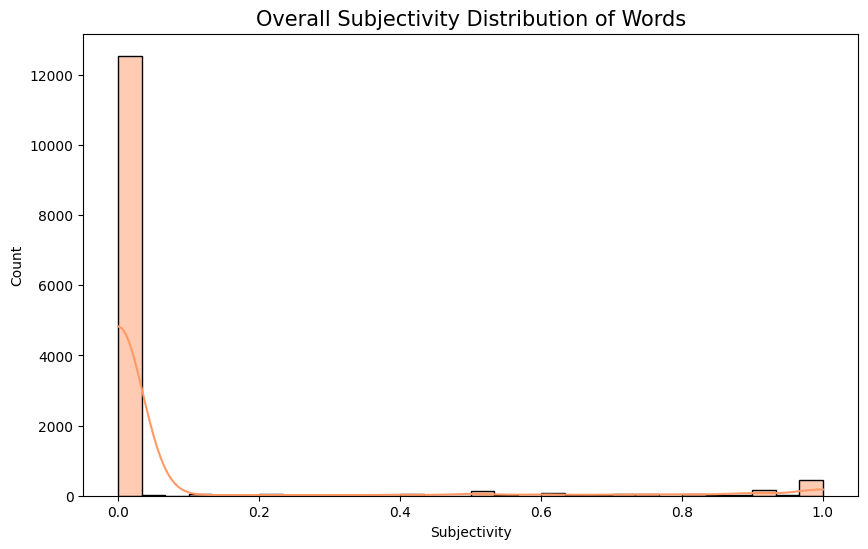

In [11]:
# Polarity & Subjectivity Distributions
plt.figure(figsize=(10,6))
sns.histplot(df['polarity'], bins=30, color='#33ccff', kde=True)
plt.title('Overall Polarity Distribution of Words', size=15)
plt.xlabel('Polarity')
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df['subjectivity'], bins=30, color='#ff9966', kde=True)
plt.title('Overall Subjectivity Distribution of Words', size=15)
plt.xlabel('Subjectivity')
plt.show()